## Helper Functions

In [406]:
import os
import re
from datetime import datetime, timedelta
import seaborn as sns  # Seaborn for enhanced boxplot aesthetics

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
from matplotlib.ticker import FuncFormatter, AutoLocator, AutoMinorLocator

ip_pattern = r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}'

log_entry_pattern = r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{3}).*Increased defcon mode to: defcon_4_monitoring'

## Get only defcon changes

In [407]:

# Function to parse the log file and extract only WARNING log entries
def extract_warning_logs(input_path, output_path):
    with open(input_path, 'r') as input_file, open(output_path, 'w') as output_file:
        for line in input_file:
            if "WARNING" in line:
                output_file.write(line)




## Concat timestamps of log files

In [408]:
def get_log_files(directory):
    """
    Retrieves all log files in the specified directory.

    :param directory: Path to the directory to search for log files.
    :return: List of paths to log files found in the directory.
    """
    log_files = [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.log')]
    return log_files


import os


def delete_logs_with_string(directory):
    """
    Deletes all log files in the specified directory that contain the target string.
    
    Args:
    - directory (str): The path to the directory containing log files.
    """
    # Check each file in the directory
    for filename in os.listdir(directory):
        if filename.endswith(f"_defcon_warn.log"):  # Check only log files
            file_path = os.path.join(directory, filename)
            try:
                os.remove(file_path)
            except Exception as e:
                print(f"Error while trying to read/delete file '{file_path}': {e}")


def concat_timestamps_for_dir(directory_path):
    # Function to read the triggerdefcon file and extract relevant log entries
    def extract_defcon_entries(file_path, pattern):
        defcon_entries = []
        with open(file_path, 'r') as file:
            for line in file:
                match = re.search(pattern, line)
                if match:
                    defcon_entries.append(match.group(1))
        return pd.DataFrame(defcon_entries, columns=['Timestamp'])

    # Function to append timestamps from other log files within the same minute
    def append_timestamps_from_files(df, log_file_paths, pattern):
        for file_path in log_file_paths:
            if 'trigger_defcon' in file_path or not '_warn' in file_path:
                continue

            file_timestamps = []
            with open(file_path, 'r') as file:
                for line in file:
                    match = re.search(pattern, line)
                    if match:
                        # Now including milliseconds in the parsing format
                        file_timestamps.append(datetime.strptime(match.group(1), '%Y-%m-%d %H:%M:%S.%f'))

            # For each timestamp in the trigger file, search for entries within the same minute in this file
            search_results = []
            for trigger_timestamp in df['Timestamp']:
                start_window = trigger_timestamp
                end_window = trigger_timestamp + timedelta(minutes=1)
                matching_timestamp = next((ts for ts in file_timestamps if start_window <= ts < end_window), None)
                search_results.append(matching_timestamp)

            match = re.search(ip_pattern, file_path)
            # Extract the IP address if a match is found
            ip_address = match.group(0)
            df[ip_address] = search_results

        return df

    # reset prvious runs
    delete_logs_with_string(directory_path)

    for log_file in get_log_files(directory_path):
        if '_eval_trigger' in log_file:
            extract_warning_logs(log_file, log_file.replace('_eval_trigger.log', '_trigger_defcon_warn.log'))
        else:
            extract_warning_logs(log_file, log_file.replace('_eval.log', '_defcon_warn.log'))

    # Assuming directory_path is set correctly
    log_file_paths = get_log_files(directory_path)
    trigger_file = next((f for f in log_file_paths if 'trigger_defcon_warn' in f), None)

    if trigger_file:
        # Create the initial DataFrame from the triggerdefcon file
        df_defcon = extract_defcon_entries(trigger_file, log_entry_pattern)
        df_defcon['Timestamp'] = pd.to_datetime(df_defcon['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
        # Append timestamps from other log files within the same minute
        # df_defcon_complete = pd.DataFrame()
        df_defcon_complete = append_timestamps_from_files(df_defcon, log_file_paths, log_entry_pattern)

        # Display the head of the complete DataFrame
        return df_defcon_complete
    else:
        print('Trigger file not found')





## Calculate delays

In [409]:
def calculate_longest_delay(df):
    # Initialize a list to store the longest delay for each row
    longest_delays = []

    # Iterate over DataFrame rows
    for index, row in df.iterrows():
        # Extract the first timestamp from the trigger file
        trigger_timestamp = row['Timestamp']

        # Initialize a variable to keep track of the longest delay for the current row
        max_delay = pd.Timedelta(0)

        # Iterate over all other columns to calculate delays
        for col in df.columns[1:]:  # Skipping the first column as it's the trigger timestamp
            if pd.isnull(row[col]):
                continue  # Skip if the timestamp is NaN
            # Calculate the time difference
            current_delay = row[col] - trigger_timestamp
            # Update max_delay if the current delay is longer
            if current_delay > max_delay:
                max_delay = current_delay

        # Append the longest delay for the current row to the list
        longest_delays.append(max_delay)

    # Add the list as a new column to the DataFrame
    df['LongestDelay'] = longest_delays
    return df




In [410]:
def get_exactly_twenty_rows(df, dir_path):
    if len(df) > 20:
        # Assuming df is your DataFrame
        # Check if the last row has any NA values
        if df.iloc[-1].isna().any():
            # Drop the last row if it has any NA values
            df = df.iloc[:-1]

        # Ensure the DataFrame has at least 20 rows
        # Keep only the last 20 rows
        df = df.tail(20)

    if len(df) < 20:
        print(f'Error: df has less than 20 rows for {dir_path}: length is {len(df)}')
    return df


# Assume directory_path is correctly defined as needed
node_names = ['c1', 'f1', 'f2', 'e1', 'e2', 'e3']
dfs_to_plot = {}

for node_name in node_names:
    directory_path_r1 = os.path.join(node_name, 'r1')
    directory_path_r2 = os.path.join(node_name, 'r2')
    directory_path_r3 = os.path.join(node_name, 'r3')

    df_r1 = concat_timestamps_for_dir(directory_path_r1)
    df_r2 = concat_timestamps_for_dir(directory_path_r2)
    df_r3 = concat_timestamps_for_dir(directory_path_r3)

    df_r1_short = get_exactly_twenty_rows(df_r1, directory_path_r1)
    df_r2_short = get_exactly_twenty_rows(df_r2, directory_path_r2)
    df_r3_short = get_exactly_twenty_rows(df_r3, directory_path_r3)

    df_concat = pd.concat([df_r1_short, df_r2_short, df_r3_short], ignore_index=True)
    df_concat_delay = calculate_longest_delay(df_concat)
    dfs_to_plot[node_name] = df_concat_delay


Error: df has less than 20 rows for f1\r3: length is 18


In [411]:
dfs_to_plot['e3']

,Timestamp,192.168.68.50,192.168.68.60,192.168.68.70,192.168.68.71,192.168.68.73,LongestDelay
0,2024-02-13 17:41:24.841,2024-02-13 17:41:24.872,2024-02-13 17:41:24.857,2024-02-13 17:41:28.906,2024-02-13 17:41:28.884,2024-02-13 17:41:31.740,0 days 00:00:06.899000
1,2024-02-13 17:42:18.299,2024-02-13 17:42:18.325,2024-02-13 17:42:18.314,2024-02-13 17:42:22.363,2024-02-13 17:42:22.335,2024-02-13 17:42:26.779,0 days 00:00:08.480000
2,2024-02-13 17:43:16.339,2024-02-13 17:43:16.369,2024-02-13 17:43:16.355,2024-02-13 17:43:20.404,2024-02-13 17:43:20.378,2024-02-13 17:43:21.822,0 days 00:00:05.483000
3,2024-02-13 17:44:16.910,2024-02-13 17:44:16.946,2024-02-13 17:44:16.925,2024-02-13 17:44:20.982,2024-02-13 17:44:20.947,2024-02-13 17:44:21.878,0 days 00:00:04.968000
4,2024-02-13 17:45:28.178,2024-02-13 17:45:28.732,2024-02-13 17:45:28.718,2024-02-13 17:45:32.769,2024-02-13 17:45:32.735,2024-02-13 17:45:36.940,0 days 00:00:08.762000
5,2024-02-13 17:46:06.363,2024-02-13 17:46:06.919,2024-02-13 17:46:06.903,2024-02-13 17:46:10.953,2024-02-13 17:46:10.927,2024-02-13 17:46:11.969,0 days 00:00:05.606000
6,2024-02-13 17:47:07.993,2024-02-13 17:47:08.026,2024-02-13 17:47:08.011,2024-02-13 17:47:12.065,2024-02-13 17:47:12.032,2024-02-13 17:47:17.025,0 days 00:00:09.032000
7,2024-02-13 17:48:32.009,2024-02-13 17:48:32.043,2024-02-13 17:48:32.027,2024-02-13 17:48:36.078,2024-02-13 17:48:36.048,2024-02-13 17:48:37.087,0 days 00:00:05.078000
8,2024-02-13 17:49:17.830,2024-02-13 17:49:17.870,2024-02-13 17:49:17.853,2024-02-13 17:49:21.899,2024-02-13 17:49:21.871,2024-02-13 17:49:22.126,0 days 00:00:04.296000
9,2024-02-13 17:50:29.097,2024-02-13 17:50:29.133,2024-02-13 17:50:29.113,2024-02-13 17:50:33.158,2024-02-13 17:50:33.981,2024-02-13 17:50:37.189,0 days 00:00:08.092000


## Plot

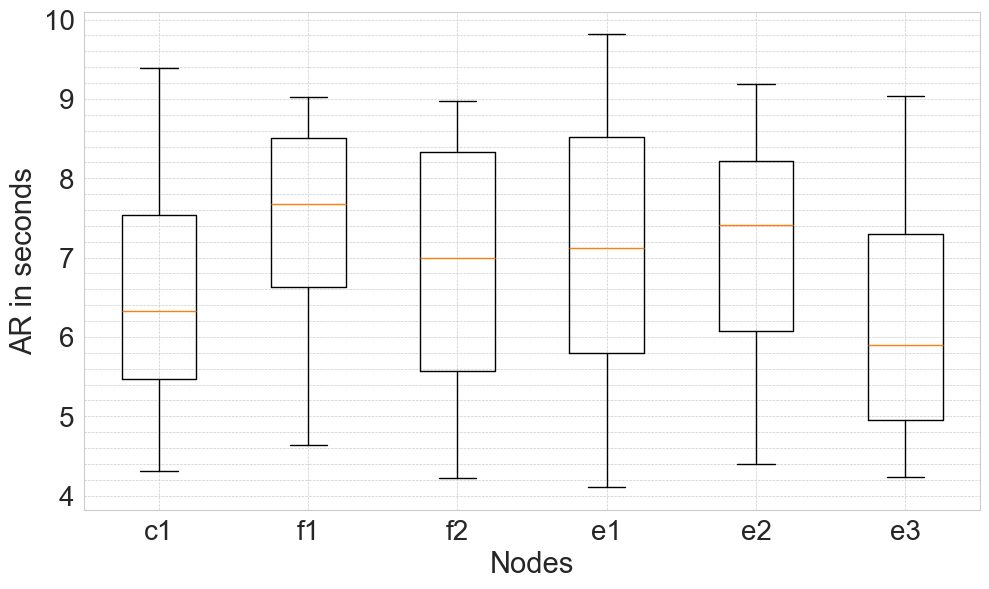

In [412]:
def custom_formatter(x, pos):
    """
    Custom formatter to scale down the tick values and remove scientific notation.

    Args:
    - x: The tick value.
    - pos: The position (unused in this formatter).

    Returns:
    - Formatted tick label as a string, scaled down by a factor of 1e9.
    """
    scaled_value = x / 1e9  # Scale down by a factor of 1e9
    return f'{scaled_value:.0f}'  # Format as an integer, removing any decimal places


data_to_plot = [df['LongestDelay'] for df in dfs_to_plot.values()]
labels = list(dfs_to_plot.keys())

# Create the boxplot
plt.figure(figsize=(10, 6))  # Adjust the size as needed
plt.boxplot(data_to_plot, labels=labels)
plt.ylabel('AR in seconds')
plt.xlabel('Nodes')

# Making y-axis ticks more fine-grained
ax = plt.gca()  # Get the current Axes instance
ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
ax.yaxis.set_major_locator(ticker.AutoLocator())  # Automatically find optimal tick locations
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())  # Add minor ticks for more granularity

# Show the plot
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Optional: Add gridlines for better readability
plt.tight_layout()  # Adjust the layout to make room for the tick labels

# Save the figure to a PDF file
plt.savefig('boxplot_longest_delay.pdf')

plt.show()  # Show the plot after saving to ensure the plot window doesn't block the script

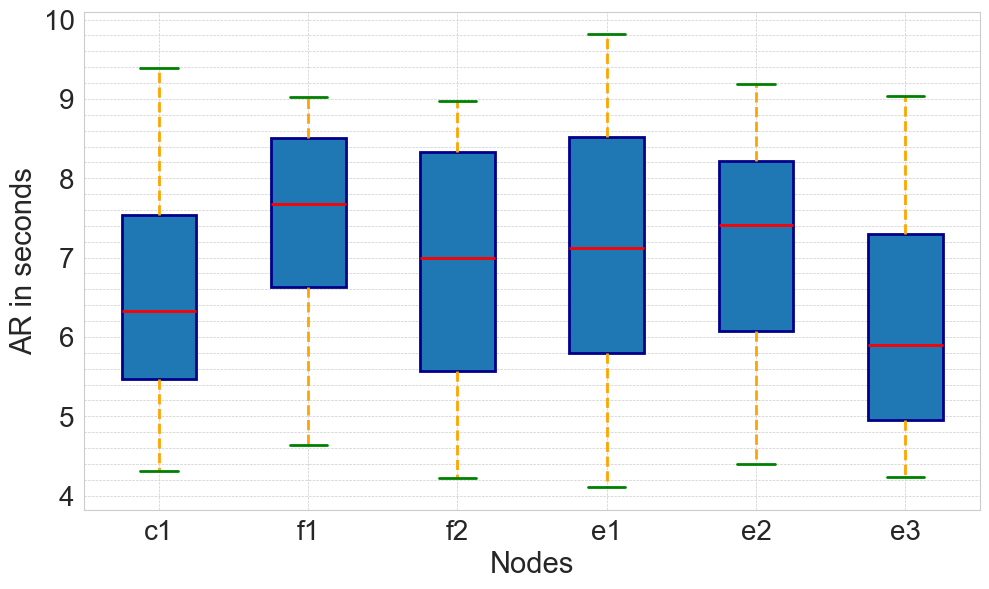

In [413]:
# Assuming dfs_to_plot is defined earlier in your script
# data_to_plot = [df['LongestDelay'] for df in dfs_to_plot.values()]
data_to_plot = [df['LongestDelay'].dt.total_seconds() for df in dfs_to_plot.values()]
labels = list(dfs_to_plot.keys())

# Create the boxplot with enhanced color scheme
plt.figure(figsize=(10, 6))  # Adjust the size as needed
boxprops = dict(linestyle='-', linewidth=2, color='darkblue')
whiskerprops = dict(linestyle='--', linewidth=2, color='orange')
capprops = dict(linestyle='-', linewidth=2, color='green')
medianprops = dict(linestyle='-', linewidth=2, color='red')
flierprops = dict(marker='o', markerfacecolor='lightblue', markersize=8, linestyle='none')

plt.boxplot(data_to_plot, labels=labels, patch_artist=True,
            boxprops=boxprops, whiskerprops=whiskerprops,
            capprops=capprops, medianprops=medianprops,
            flierprops=flierprops)

plt.ylabel('AR in seconds')
plt.xlabel('Nodes')

# Making y-axis ticks more fine-grained
ax = plt.gca()  # Get the current Axes instance
# ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
ax.yaxis.set_major_locator(ticker.AutoLocator())  # Automatically find optimal tick locations
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())  # Add minor ticks for more granularity

# Optional: Add gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()  # Adjust the layout to make room for the tick labels

# Save the figure to a PDF file
plt.savefig('boxplot_longest_delay.pdf')

plt.show()  # Show the plot after saving to ensure the plot window doesn't block the script


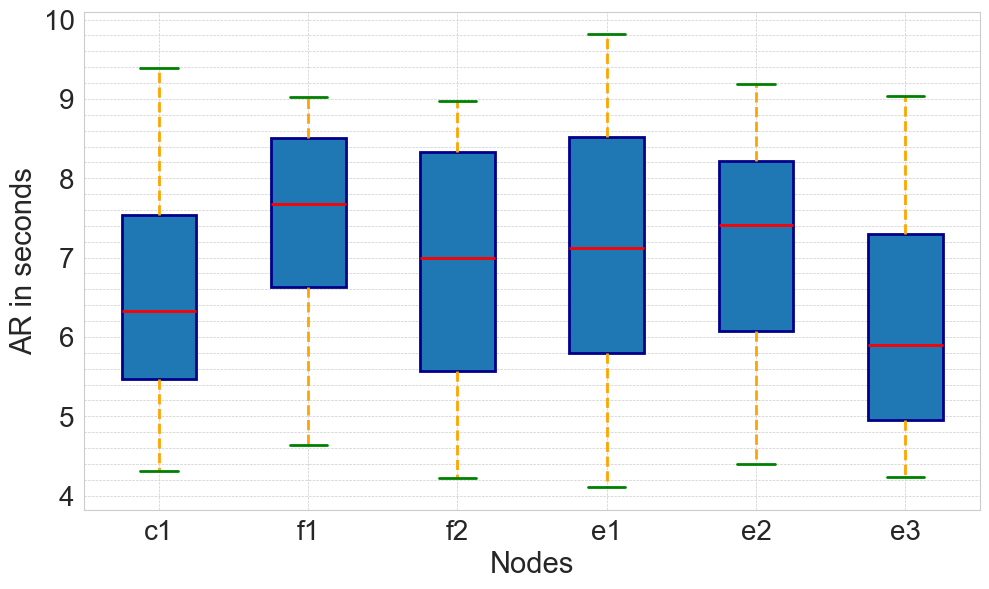

In [414]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import matplotlib

# Set larger font sizes for all plot elements
matplotlib.rc('xtick', labelsize=20)  # Increase x-tick label size
matplotlib.rc('ytick', labelsize=20)  # Increase y-tick label size
matplotlib.rc('axes', labelsize=21)  # Increase axis label size
matplotlib.rc('axes', titlesize=21)  # Increase the title size if you have one

# Assuming dfs_to_plot is defined earlier in your script
data_to_plot = [df['LongestDelay'].dt.total_seconds() for df in dfs_to_plot.values()]
labels = list(dfs_to_plot.keys())

# Create the boxplot with enhanced color scheme and readability for IEEE format
plt.figure(figsize=(10, 6))  # Adjust the size as needed
boxprops = dict(linestyle='-', linewidth=2, color='darkblue')
whiskerprops = dict(linestyle='--', linewidth=2, color='orange')
capprops = dict(linestyle='-', linewidth=2, color='green')
medianprops = dict(linestyle='-', linewidth=2, color='red')
flierprops = dict(marker='o', markerfacecolor='lightblue', markersize=8, linestyle='none')

plt.boxplot(data_to_plot, labels=labels, patch_artist=True,
            boxprops=boxprops, whiskerprops=whiskerprops,
            capprops=capprops, medianprops=medianprops,
            flierprops=flierprops)

plt.ylabel('AR in seconds')  # Adjust font size for Y axis label
plt.xlabel('Nodes')  # Adjust font size for X axis label

# Making y-axis ticks more fine-grained
ax = plt.gca()  # Get the current Axes instance
ax.yaxis.set_major_locator(ticker.AutoLocator())  # Automatically find optimal tick locations
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())  # Add minor ticks for more granularity

# Optional: Add gridlines for better readability
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()  # Adjust the layout to make room for the tick labels

# Save the figure to a PDF file
plt.savefig('boxplot_longest_delay_v1.pdf', format='pdf', bbox_inches='tight')

plt.show()  # Show the plot after saving to ensure the plot window doesn't block the script
